- Introducing generative models for synthesizing new data;
- Autoencoders, variational autoencoders, and their relationship to GANs;
- Understanding he building blocks of GANs;
- Implementing a simple GAN model to generate handwritten digits;
- Understanding transposed convolution and batch normalization;
- Improving GANs: deep convolutional GANs and GANs using the Wasserstein distance.

# Introducing generative adversarial networks

The overall objective of a GAN is to synthesize new data that has the same distribution as its training dataset. They 
are considered to be in the unsupervised learning category of machine learning tasks, since no labeled data is required.

While the original GAN architecture proposed in this paper was based on fully connected layers, similar to multilayer
perceptron architectures, and trained to generate low-resolution MNIST-like handwritten digits, it served more as a
proof of concept to demonstrate the feasibility of this new approach.

# Starting with autoencoders

While standard autoencoders cannot generate new data, understanding their function will help you better understand GANs.

Autoencoders are composed of two networks concatenated together: an encoder network and a decoder network. The encoder
network receives a $d$ dimensional input feature vector associated with example $x$ and encodes it into a $p$
dimensional vector $z$. In other words, the role of the encoder is to learn how to model the function $z = f(x)$.

The encoded vector, $z$, is also called the latent vector, or the latent feature representation. Typically, the
dimensionality of the latent vector is less than that of the input examples ($p<d$). Hence, we can say that the encoder
acts as a data compression function.

Then, the encoder decompresses $\hat{x}$ from the lower-dimensional latent vector, $z$, where we can thing of the
encoder as a function $\hat{x}=g(z)$.

> Notice that there are variants of autoencoders that use a latent space of bigger dimensionality compared to the
> dimensionality of the input. This is especially usefull in the context of de-noising.

# Generative model for synthesizing new data
Autoencoders are deterministic models, so they are just able to reconstruct an image from its latent feature
representation. They are not able to generate data beyound reconstructing its input through the transformation of the
compressed representation.

A generative model, on the other hand, can generate a new example, $\~x$, from a random vector, $z$ (corresponding to
the latent representation).

We can notice some similarities between the decoder of the autoencoder and a generative model. However a major
difference between the two is that we do not know the distribution of $z$ in the autoencoder, while in the generative
model, the distribution of $z$ is fully characterizable. One approach to generalize an autoencoder int oa generative
model is the variational autoencoder (VAE).

In a VAE receiving an input example, $x$, the encoder network is modified in such a way that it computes two moments of
the distribution of the latent vector: the mean, $\mu$ and the variance $\sigma^2$. During the training of a VAE, the
network is forced to match these moments with those of a standard normal distribution (zero mean and unit variance).
Then, after the VAE model is trained, the encoder is discarded and we can use the decoder network to generate new
examples, $\~x$, by feeding random $z$ vectors from the "learned" gaussian distribution.

# Generating new samples with GANs

Let's assume we have a network generator $G$ so that $\~x = G(z)$, where $z$ is a random vector, sampled from a known
ditribution. As always, we will initialize this network with random weights. Therefore, the first output images, before
the weights are adjusted, will look like white noise.

Now, imagine there is a function that can assess the quality of images (assessor function). We can use the feedback from
that function to tell our generator network how to adjust its weights to improve the quality of the generated images.

While an assessor function, as described in the previous paragraph, would make the image generation task very easy, the
question is whether such a universal function to assess the quality of images exists and how it is defined.

GAN model consists of an additional NNcalled discriminator (D), which is a classifier that learns to detect a
synthesized image, $\~x$, from a real image $x$.

In a GAN model, the two networks, generator and discriminator, are trained together. Over time, both networks become
better as they interact with each other. In fact, the two networks play an adversarial game, where the generator learns
to improve its output to be able to fool the discriminator. At the same time, the discriminator becomes better at
detecting the synthesized images.

## Understanding the loss function of the generator and discriminator networks in a GAN model
$$
V(\theta^{(D)},\theta^{(G)}) = E_{x~p_{data}(x)}[\log{D(x)}] + E_{z~p_z(z)}[\log{(1-D(G(z)))}]
$$

Here, $V(\theta^{(D)},\theta^{(G)})$ is called the value function, which can be interpreted as a payoff: we want to
maximize its value with respect to the discriminator, while minimizing its value with respect to the generator.

$D(x)$ is the probability that indicates whether the input example, $x$ (that is generated), is real or fake.

The expression $E_{x~p_{data}(x)}[\log{D(x)}]$ refers to the expected value (averaging though all the samples) of the
quantity in brackets with respect to the examples from the data distribution (distribution of the real examples).
$E_{z~p_z(z)}[\log{(1-D(G(z)))}]$ refers to the expected value of the quantity with respect to the distribution of the
input, $z$, vectors.

A practical way of training GANs is to alternate between these two optimization steps:
1. Freeze the parameters of one network and optimie the weights of the other one;
2. Freeze the second network and optimize the first one;
3. Repeat at each training iteration.

Let's assume that the generator network is fixed, and we want to optimize the discriminator. Both terms in the value
function contribute to optimizing the discriminator, where the first term corresponds to the loss associated with the
real examples, and the second term is the loss for the fake examples.

Therefore, when $G$ is fixed, our objective is to maximize the value function, which means making the discriminator
better at distinguishing between real and generated images.

After optimizing the discriminator using the loss terms for real and fake samples, we then fix the discriminator and
optimize the generator. In this case, only the second term of the value function contributes to the gradients of the
generator. As a result, when $D$ is fixed, our objective is to minimize the value function.

However, $\log{(1-D(G(z)))}$ suffers from vanishing gradients in the early training stages (early in the learning
process generated outputs look nothing like real examples, therefore, $D(G(z))$ will be close to zero). This phenomenon
is called saturation. To resolve this issue, we can reformulate the maximization objective to the minimization of
$E_{z~p_z(z)}[\log{(D(G(z)))}]$. If we are using this technique we have to swap the labels of real and fake examples (1
will be assigned to fake images, 0 otherwise).

## Implementing a GAN from scratch

In [2]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def make_generator_network(input_size = 20, num_hidden_layers = 1, num_hidden_units = 100,  num_output_units = 784):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f"hidden{i}",nn.Sequential(
            nn.Linear(input_size,num_hidden_units),
            nn.LeakyReLU(),
        ))
        input_size = num_hidden_units
    model.add_module("prediction_head",nn.Sequential(
        nn.Linear(input_size,num_output_units),
        nn.Tanh()
    ))
    return model

def make_discriminator_network(input_size, num_hidden_layers = 1, num_hidden_units = 100,  num_output_units = 1):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f"hidden{i}",nn.Sequential(
            nn.Linear(input_size,num_hidden_units),
            nn.LeakyReLU(),
            nn.Dropout()
        ))
        input_size = num_hidden_units
    model.add_module("prediction_head",nn.Sequential(
        nn.Linear(input_size,num_output_units),
        nn.Sigmoid()
    ))
    return model

In [3]:
image_size = (28,28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

import torch
torch.manual_seed(1)
gen_model = make_generator_network(z_size,gen_hidden_layers,gen_hidden_size,np.prod(image_size))
disc_model = make_discriminator_network(np.prod(image_size),disc_hidden_layers,disc_hidden_size)

In [4]:
import torchvision
import torchvision.transforms.v2 as t
image_path = '../NNs with PyTorch/'
transform = t.Compose([
    t.ToImage(),
    t.ToDtype(torch.float32,scale=True),
    t.Normalize(mean=[0.5],std=[0.5])
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,train=True,transform=transform,download=False)

/Users/riccardotoniolo/miniconda3/envs/mllib/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size,z_size)*2 - 1
    elif mode_z == "normal":
        input_z = torch.randn(batch_size,z_size)
    return input_z

In [6]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
device = "mps"
mnist_dl = DataLoader(
    mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size),
).to(device)
disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size,
).to(device)
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())
mode_z = "uniform"

In [7]:
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()


def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [8]:
fixed_z = create_noise(batch_size,z_size,mode_z).to(device)
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output,(batch_size, *image_size))
    return (images+1)/2

epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 100
torch.manual_seed(1)
for epoch in range(1, num_epochs + 1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(
        f"Epoch {epoch:03d} | Avg Losses >>"
        f" G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}"
        f" [D-Real: {all_d_real[-1]:.4f} D-Fake: {all_d_fake[-1]:.4f}]"
    )
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 1.4675/0.5866 [D-Real: 0.8773 D-Fake: 0.3288]
Epoch 002 | Avg Losses >> G/D 0.8591/1.1609 [D-Real: 0.6106 D-Fake: 0.4532]
Epoch 003 | Avg Losses >> G/D 1.1555/1.0438 [D-Real: 0.6454 D-Fake: 0.3814]
Epoch 004 | Avg Losses >> G/D 0.9994/1.1473 [D-Real: 0.5993 D-Fake: 0.4003]
Epoch 005 | Avg Losses >> G/D 1.0814/1.1487 [D-Real: 0.6015 D-Fake: 0.3959]
Epoch 006 | Avg Losses >> G/D 1.0299/1.1625 [D-Real: 0.5965 D-Fake: 0.4001]
Epoch 007 | Avg Losses >> G/D 1.0570/1.1688 [D-Real: 0.5965 D-Fake: 0.3988]
Epoch 008 | Avg Losses >> G/D 1.0057/1.1898 [D-Real: 0.5879 D-Fake: 0.4105]
Epoch 009 | Avg Losses >> G/D 1.0240/1.1773 [D-Real: 0.5925 D-Fake: 0.4045]
Epoch 010 | Avg Losses >> G/D 1.0201/1.1883 [D-Real: 0.5897 D-Fake: 0.4086]
Epoch 011 | Avg Losses >> G/D 1.0036/1.1658 [D-Real: 0.5987 D-Fake: 0.4063]
Epoch 012 | Avg Losses >> G/D 1.0372/1.1803 [D-Real: 0.5950 D-Fake: 0.4065]
Epoch 013 | Avg Losses >> G/D 1.0200/1.1680 [D-Real: 0.5986 D-Fake: 0.4056]
Epoch 014 | 

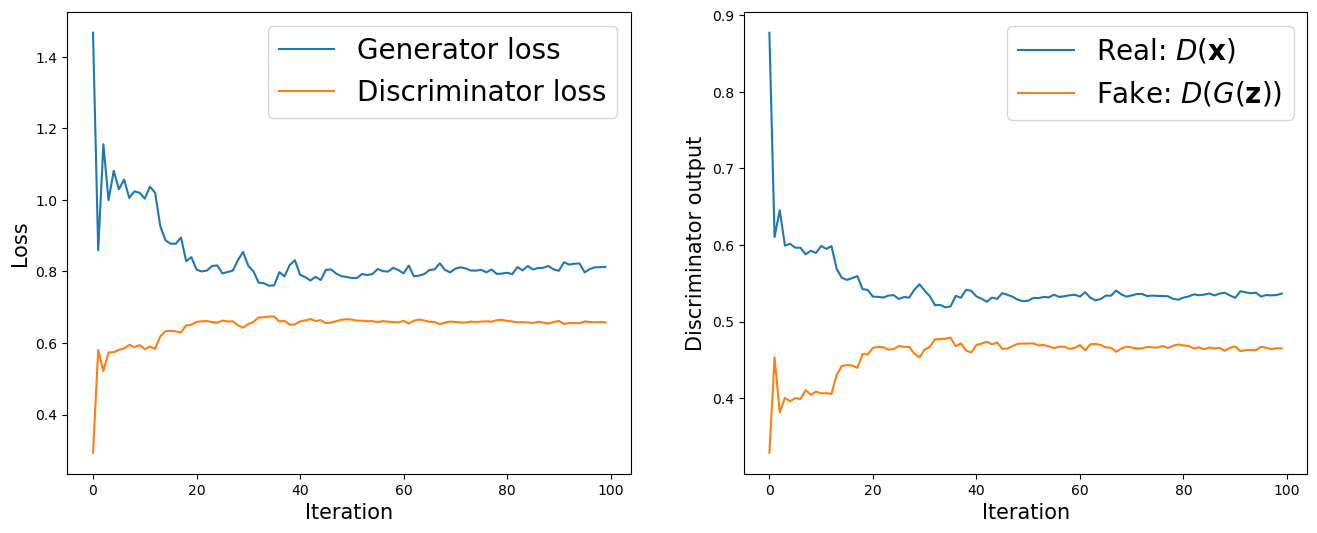

In [10]:
import itertools
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,2,1)
plt.plot(all_g_losses,label="Generator loss")
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses,label="Discriminator loss")
plt.legend(fontsize=20)
ax.set_xlabel("Iteration",size=15)
ax.set_ylabel("Loss",size=15)

ax = fig.add_subplot(1,2,2)
plt.plot(all_d_real,label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake,label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel("Iteration",size=15)
ax.set_ylabel("Discriminator output",size=15)
plt.show()

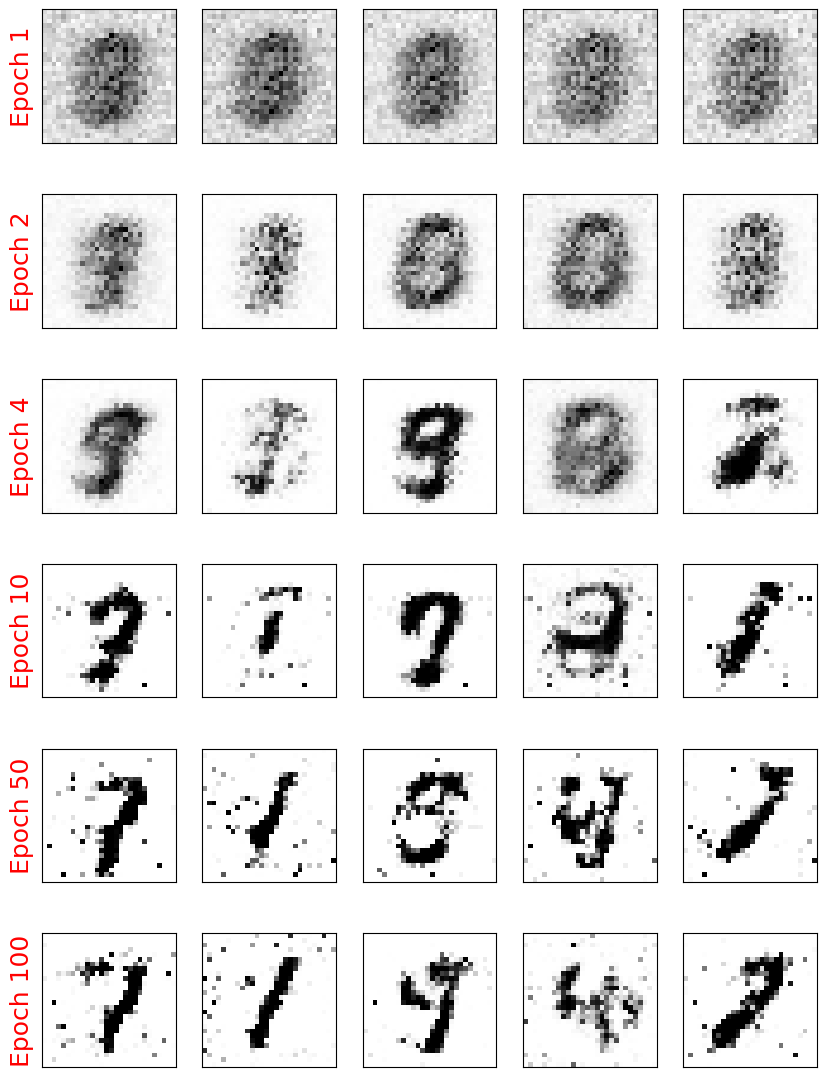

In [13]:
selected_epochs = [1,2,4,10,50,100]
fig = plt.figure(figsize=(10,14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6,5,i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(-0.06,0.5,f'Epoch {e}',rotation=90, size=18, color='red',
                    horizontalalignment='right',verticalalignment='center', transform=ax.transAxes
            )
        image = epoch_samples[e-1][j]
        ax.imshow(image,cmap='gray_r')

plt.show()

Even after 100 epochs, the produced images still look very different from the handwritten digits contained in the MNIST
dataset. We have to remember that we just used one hidden layer (fully connected), and that convolutions are a better
choice, generally, for image processing.

# Improving the quality of synthesized images using a convolutional and Wasserstein GAN

The technique that we will cover in this section will include:
- Transposed convolutions;
- Batch normalization;
- WGAN.

In the DCGAN's paper, the researchers proposed using convolutional layers for both the generator and discriminator
networks. Starting from a random vector, $z$, the DCGAN first uses a fully connected layer to project $z$ into a new
vector wit a proper size so that it can be reshaped into a spatial convolution representation, which is smaller than the
output image. Then, a series of convolutional layers, known as transposed convolution, are used to upsample the feature
maps to the desired output image size.

## Transposed convolution

While a convolution operation is usually used to downsample the feature space, a transposed convolution operation is
usually used for upsampling the feature space.

Assume that we have an input feature map of size $n\times n$. Then, we apply a 2D convolution operation with certain
padding and stride parameters to this $n\times n$ input, resulting in an output feature map of size $m\times m$. Now the
question is, how can we apply another convolution operation to obtain a feature map with the initial dimension
$n\times n$ from this $m\times m$ output feature map while maintaining the connectivity patterns between the input and
output?

Upsampling feature maps using transposed convolution works by inserting 0s between the elements fo the input feature
maps. Then it's like applying a convolution of kernel size $2\times2$.

## Batch normalization

One of the main ideas behind Batch Norm is normalizing the layer inputs (indipendently on the features) and preventing
changes in their distribution during training, which enables faster and better convergence.

BatchNorm transforms a mini-batch of features beased on its computed statistics. Assume that we have the net
preactivation feature maps obtained after a convolutional layer in a four-dimensional tensor, $Z$, with the shape
$m\times c\times h\times w$, where $m$ is the number of examples in the batch, $h\times w$ is the spatial dimension and
$c$ is the number of channels. BatchNorma can be summerized in three steps:
1. Compute the mean and standard deviation of the net inputs for each minibatch;
2. Standardize the net inputs for all examples in the batch;
3. Scale and shift the normalized net inputs using two learnable parameter vectors, $\gamma$ and $\beta$, of size $c$.

The shifting and spreading done in step 3 is used mainly because otherwise sigmoid activations would result in linear
regions (since the batch set will be centered to zero, the sigmoid will output many values near 0.5, losing its
expressive power) for values close to zero (since the output of phase 2 is something centered in zero and with unit
variance).

## Implementing the generator and discriminator

In [27]:
def make_generator_network(input_size,n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size,n_filters*4,4,1,0,bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters*4,n_filters*2,3,2,1,bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters*2,n_filters,4,2,1,bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters,1,4,2,1,bias=False),
        nn.Tanh()
    )
    return model

In [28]:
class Discriminator(nn.Module):
    def __init__(self,n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1,n_filters,4,2,1,bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters,n_filters*2,4,2,1,bias=False),
            nn.BatchNorm2d(n_filters*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters*2,n_filters*4,3,2,1,bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters*4,1,4,1,0,bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.network(input).view(-1,1).squeeze(0)

In [29]:
z_size = 100
image_size = (28,28)
n_filters = 32
gen_model = make_generator_network(z_size,n_filters).to(device)
disc_model = Discriminator(n_filters).to(device)
loss = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(),0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(),0.0002)

In [30]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size,z_size,1,1)*2 - 1
    elif mode_z == "normal":
        input_z = torch.randn(batch_size,z_size,1,1)
    return input_z


def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()


def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [31]:
epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 100

fixed_z = create_noise(batch_size,z_size,mode_z).to(device)
torch.manual_seed(1)
for epoch in range(1, num_epochs + 1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(
        f"Epoch {epoch:03d} | Avg Losses >>"
        f" G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}"
        f" [D-Real: {all_d_real[-1]:.4f} D-Fake: {all_d_fake[-1]:.4f}]"
    )
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 4.4156/0.1302 [D-Real: 0.9469 D-Fake: 0.0589]
Epoch 002 | Avg Losses >> G/D 4.2090/0.1713 [D-Real: 0.9298 D-Fake: 0.0685]
Epoch 003 | Avg Losses >> G/D 3.3716/0.3133 [D-Real: 0.8796 D-Fake: 0.1192]
Epoch 004 | Avg Losses >> G/D 3.0229/0.3712 [D-Real: 0.8591 D-Fake: 0.1397]
Epoch 005 | Avg Losses >> G/D 2.8238/0.3816 [D-Real: 0.8557 D-Fake: 0.1440]
Epoch 006 | Avg Losses >> G/D 2.8202/0.3521 [D-Real: 0.8644 D-Fake: 0.1355]
Epoch 007 | Avg Losses >> G/D 2.8018/0.3751 [D-Real: 0.8571 D-Fake: 0.1427]
Epoch 008 | Avg Losses >> G/D 2.7656/0.3558 [D-Real: 0.8614 D-Fake: 0.1377]
Epoch 009 | Avg Losses >> G/D 2.7565/0.3838 [D-Real: 0.8544 D-Fake: 0.1457]
Epoch 010 | Avg Losses >> G/D 2.7943/0.3586 [D-Real: 0.8612 D-Fake: 0.1382]
Epoch 011 | Avg Losses >> G/D 2.8896/0.3619 [D-Real: 0.8613 D-Fake: 0.1383]
Epoch 012 | Avg Losses >> G/D 2.8377/0.3447 [D-Real: 0.8656 D-Fake: 0.1344]
Epoch 013 | Avg Losses >> G/D 2.8554/0.3346 [D-Real: 0.8702 D-Fake: 0.1296]
Epoch 014 | 

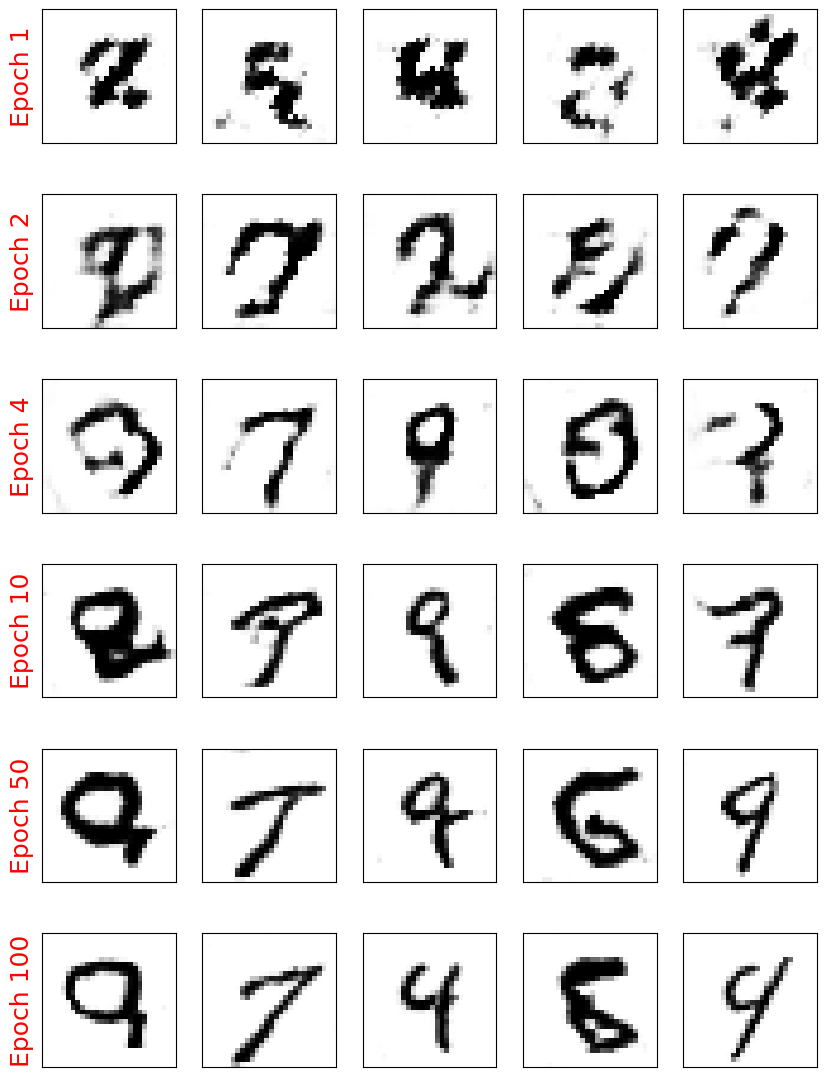

In [32]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06,
                0.5,
                f"Epoch {e}",
                rotation=90,
                size=18,
                color="red",
                horizontalalignment="right",
                verticalalignment="center",
                transform=ax.transAxes,
            )
        image = epoch_samples[e - 1][j]
        ax.imshow(image, cmap="gray_r")

plt.show()

There is a theoretical argument that training the generator should seek to minimize the dissimilarity between the
distribution observed in the real data and the distribution observed in synthesized examples. Hence our current
architecture would not perform very well when using cross-entropy as a loss function (it serves the purpose of trying to
fool the discriminator, which is an indirect way of minimizing the distribution dissimilarity).

In this case, distribution over images means the distribution of the underlying structure:
- Are there more "1" than "9" as drawings? (remember that no label is used);
- Are some digits written more sloppily than others?
- Are certain shapes, textures, pixel patterns more common than others?

Those questions are all covering the distribution of the data.

## Dissimilarity measures between two distributions

As mentioned at the beginning of the chapter, the goal of a generative model is to learn how to synthesize new samples
that have the same distribution as the distribution of the training dataset.

We will refer to $P(x)$ and $Q(x)$ to different distribution of a random variable $x$.

### Total variation (TV) distance
$$TV(P,Q) = \sup_x|P(x)-Q(x)|$$
The supremum function $\sup(S)$, refers to the smallest value that is greater than all elements of $S$ (in this case $S$
is represented by the $|P(x)-Q(x)|$ distribution).

$TV$ measures the largest difference between the two distributions at each point, and selects the biggest of them all.

### Earth mover's (EM) distance
$$EM(P,Q) = \inf_{\gamma\in\prod(P,Q)}E_{(u,v)\in\gamma}(||u-v||)$$
The infinimum function, $\inf(S)$, refers to the largest value that is smaller than all elements of S.

Here the formula is searching for the $\gamma$ amongst all the combinations generated by the joint distribution
($\prod$) between $P$ and $Q$, that minimizes the mean (expected value $E$) difference between each element of $P$ ($u$)
and the corresponding element of $Q$ ($v$).

Think about it as having two piles of earth, one with a certain distribution over space $P$ and another one with a
different one from $P$, $Q$. In this case the Earth Mover's Distance is the minimum cost of turning one pile into the
other (you have to move mass from one place to another ($u$ to $v$), and the cost is the amount of mass times the
distance you move it (the expected value of the distance)).

In fact the infimum function is taken over $\prod(P,Q)$, which is the collection of all joint distribution whose
marginals are P or Q. $\gamma(u,v)$ is called the transfer plan, which indicates how we redistribute the earth from
location $u$ to $v$, subject to some constraints for maintaining valid distributions after such transfers. Computing
the EM distance is the optimization problem of finding the optimal transfer plan.

### Kullback-Leibler (KL) divergence
$$KL(P||Q)=\int P(x)\log{\frac{P(x)}{Q(x)}}dx$$

It tells how inefficient is to assume that the data is from $Q$ when it's really from $P$.

The $\frac{P(x)}{Q(x)}$ measures how much $Q$ underastimates ($P(x) > Q(x)$) or oversatimates ($P(x) < Q(x)$) the
probability of $x$, relative to the truth $P$. The measure is then weighted by the probability that $P$ assigns to $x$,
since we care less if $x$ it's pretty unlikely for $P$, but we care a lot if it isn't. The integral is used to compute
the expected value of the penalty.

Notice that using the $\log$ for the ratio between $P$ and $Q$ serves the purpose of penalizing more overestimates that
underastimates (since the shape of the $\log$ function is built that way).

Note that the formula is asymmetrical ($KL(P||Q)\neq KL(Q||P)$), since swapping the parameters means inverting the ratio
and weighting differently the integral. The first one tends to make $Q$ spread out more, to cover all the regions where
$P$ has support, while the latter one tends to make $Q$ collapse to one or few high-probability regions of $P$.

#### The relationship between KL divergence and cross-entropy

KL divergence measures the relative entropy of the distribution, $P$, with respect to a reference distribution $Q$.

For discrete distributions the KL divergence can be written as:
$$KL(P||Q)=-\sum P(x_i)\log{\frac{P(x_i)}{Q(x_i)}}$$
Which can be similarly extended as:
$$KL(P||Q)=-\sum P(x_i)\log{Q(x_i)}-(-\sum P(x_i)\log{P(x_i)})$$

Based on the extended formulation, KL divergence is viewed as the cross-entropy between $P$ and $Q$ (the first term)
subtracted by the self-entropy of $P$ (second term), that is $KL(P||Q)=H(P,Q)-H(P)$.


### Jensens-Shannon (JS) divergence
$$JS(P,Q)=\frac{1}{2}(KL(P||\frac{P+Q}{2})+KL(Q||\frac{P+Q}{2}))$$

It's a symmetrical re-interpretation of the KL divergence. Unfortunately by the way it's stuctured it can result in a
vanished gradient. However, it won't be infinite like KL always by the way it's structured.

## Going back to how distance measures are related to GANs

It can be mathematically shown that the loss function in the original GAN indeed minimizes the JS divergence between the
distribution of real and fake examples. However JS divergence has problems training a GAN model, and therefore, in order
to improve the training, the researchers proposed using the EM distance as a measure of dissimilarity between the
distrbution of real and fakes examples.

Now, let's fous our attention on how EM distance can be used to train a GAN model. Let's assume $P_r$ is the
distribution of the real examples and $P_g$ denotes the distributions of fake (generated) examples. As we mentioned
earlier, computing the EM distance is an optimization problem by itself (therefore it becomes computationally
intractable). Fortunately though, the computation of the EM distance can be simplified using a theorem called
Kantorovich-Rubinstein duality, as follows:
$$W(P_r,P_g) = \sup_{||f||_L\leq1}E_{u\in P_r}[f(u)]-E_{v\in P_g}[f(v)]$$

Here the supremum is taken over all the *1-Lipshitz* continuous functions denoted by $||f||_L\leq1$.

A function $f:R\rightarrow R$, that satisfies the property $|f(x_1)-f(x_2)|\leq K|x_1-x_2|$ is called K-Lipshitz
continuous. In the previous case $K=1$.

Note that 

Now, instead of solving a complex transport problem we now just search for a function $f$ and maximize the difference
in expectations between real and generated samples s.t. the constraint that $f$ is 1-Lipschitz (this is what the
supremum wants to find). 

### Using EM distance in practice for GANs

Recall that we consider deep NNs to be universal function approximators. This means that we can simply train a NN model
to approximate the Wasserstein distance function.

In the previous section, the simple GAN uses a discriminator in the form of a classifier. For WGAN, the discriminator
can be changed to behave as a critic, which returns a scalar score instead of a probability value (we can interpret
this score as how realistic the input images are).

To train a GAN using the Wasserstein distance, the losses for the discriminator, D, and generator, G, are trained as
follows. The critic (discriminator) returns its outputs for the batch of real images examples and the batch of
synthesized examples. We use the notations $D(x)$ and $D(G(X))$ respectively.

Then teh following loss terms can be defined:
$$L^D_{real} = -\frac{1}{N}\sum_i D(x_i)$$
$$L^D_{fake} = \frac{1}{N}\sum_i D(G(z_i))$$
$$L^G = -\frac{1}{N}\sum_i D(G(z_i))$$

That will be all for the WGAN, except that we need to ensure that the 1-Lipshitz property of the critic function is
preserved during training. For this purpose, the WGAN paper proposes clamping the wights to a small region
(i.e. [-0.01,0.01]).

### Gradient penalty

In the original paper, weight clipping is suggested for the 1-Lipscitz property of the discriminator. However in another
paper titled *Improved Training of Wasserstein GANs*, researchers showed that clipping the weights can lead to exploding
and vanishing gradients. Furthermore, weight clipping can also lead to capacity underuse, which means that the critic
network is limited to learning only some simple functions.

Therefore, rather than clipping the weights, researchers proposed gradient penalty as an alternative solution. The
result is the WGAN with gradient penalty (WGAN-GP).

The procedure for the GP that is added in each iteration can be summerized by the following sequence of steps:
1. For each pair of real and fake examples ($x^{[i]},\~x^{[i]}$) in a given batch, choose a random number,
$\alpha^{[i]}$, sampled from a uniform distribution, that is $\alpha^{[i]}\in U(0,1)$.
2. Calculate an interpolation between the real and fake examples: $\hat{x}^{[i]}=\alpha x^{[i]} + (1-\alpha)\~x^{[i]}$,
resuling in a batch of interpolated examples.
3. Compute the discriminator (critic) output for all the interpolated examples, $D(\hat{x}^{[i]})$.
4. Calculate the gradients of the critic's output with respect to each interpolated example, that is,
$\nabla_{\hat{x}^{[i]}}D(\hat{x}^{[i]})$.
5. Compute the GP as:
$$L^D_{gp} = \frac{1}{N}\sum_i(||\nabla_{\hat{x}^{[i]}}D(\hat{x}^{[i]})||_2-1)^2$$

> Note that the norm of the gradient tells you the maximum rate of increase of the functin at point $x$.

Then the total loss for the discriminator is as follows:
$$L^D_{total} = L^D_{real}+L^D_{fake}+\lambda L^D_{gp}$$
Here, $\lambda$ is a tunable hyperparameter.

## Implementing a WGAN-GP to train the DCGAN model

In [83]:
def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters * 4, 4, 1, 0, bias=False),
        nn.InstanceNorm2d(n_filters * 4),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters * 4, n_filters * 2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters * 2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters * 2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh(),
    )
    return model


class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters, n_filters * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters * 2, n_filters * 4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [84]:
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)
lambda_gp = 10.0
num_epochs = 100
critic_iterations = 5

In [ ]:
from torch.autograd import grad as torch_grad


def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)

    # Calculate interpolation
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data

    proba_interpolated = disc_model(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(
        outputs=proba_interpolated, # the outputs to be considered
        inputs=interpolated, # the gradients will be computed w.r.t. those inputs
        grad_outputs=torch.ones(proba_interpolated.size(), device=device), # used to multiply the gradients
        create_graph=True, # Here we are saying to PyTorch that we don't just want the gradient values but we want also
        # to be able to compute gradients of those gradients later.
        retain_graph=True, # Here we are saying PyTorch to keep the computational graph alive. The graph will be freed
        # upon calling the .backward method to save memory.
    )[0] # gives us the gradients instead of modifying the .grad fields

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1) ** 2).mean()

In [ ]:
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # Calculate probabilities on real and generated data
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = (
        d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    )
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item()


def g_train_wgan(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_generated = disc_model(g_output)
    g_loss = -d_generated.mean()

    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [88]:
epoch_samples_wgan = []
torch.manual_seed(1)
for epoch in range(1,num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [],[]
    for i, (x, _) in enumerate(mnist_dl):
        for _ in range(critic_iterations): # This is done to better train the critic, since we want to ensure the
            # 1-Lipschitz
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))

    print(f'Epoch {epoch:03d} | D Loss >> {torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples_wgan.append(create_samples(gen_model,fixed_z).detach().cpu().numpy())

Epoch 001 | D Loss >> -0.5116
Epoch 002 | D Loss >> -0.5086
Epoch 003 | D Loss >> -0.5018
Epoch 004 | D Loss >> -0.4916
Epoch 005 | D Loss >> -0.4786
Epoch 006 | D Loss >> -0.4734
Epoch 007 | D Loss >> -0.4703
Epoch 008 | D Loss >> -0.4635
Epoch 009 | D Loss >> -0.4683
Epoch 010 | D Loss >> -0.4590
Epoch 011 | D Loss >> -0.4580
Epoch 012 | D Loss >> -0.4566
Epoch 013 | D Loss >> -0.4612
Epoch 014 | D Loss >> -0.4570
Epoch 015 | D Loss >> -0.4589
Epoch 016 | D Loss >> -0.4540
Epoch 017 | D Loss >> -0.4586
Epoch 018 | D Loss >> -0.4602
Epoch 019 | D Loss >> -0.4565
Epoch 020 | D Loss >> -0.4516
Epoch 021 | D Loss >> -0.4574
Epoch 022 | D Loss >> -0.4538
Epoch 023 | D Loss >> -0.4571
Epoch 024 | D Loss >> -0.4603
Epoch 025 | D Loss >> -0.4569
Epoch 026 | D Loss >> -0.4618
Epoch 027 | D Loss >> -0.4572
Epoch 028 | D Loss >> -0.4601
Epoch 029 | D Loss >> -0.4628
Epoch 030 | D Loss >> -0.4622
Epoch 031 | D Loss >> -0.4632
Epoch 032 | D Loss >> -0.4623
Epoch 033 | D Loss >> -0.4619
Epoch 034 

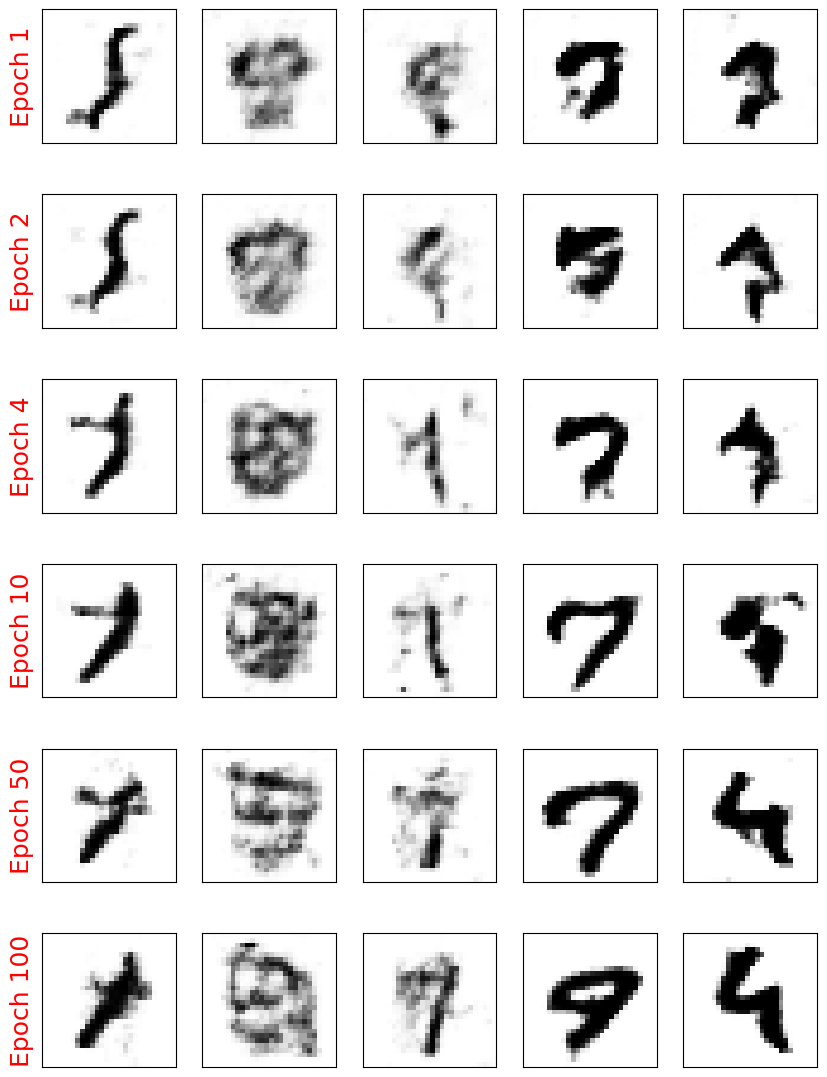

In [91]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06,
                0.5,
                f"Epoch {e}",
                rotation=90,
                size=18,
                color="red",
                horizontalalignment="right",
                verticalalignment="center",
                transform=ax.transAxes,
            )
        image = epoch_samples_wgan[e - 1][j]
        ax.imshow(image, cmap="gray_r")

plt.show()

### Mode collapse
GANs are notoriously hard to train. One common cause of failure in training GANs is when the generator gets stuck in a
small subspace and learns to generate similar samples (called mode collapse).

# Other GAN applications

It is worth mentioning that we covered GANs in an unsupervised fashion (no class labels were used). However, the GAN
approach can be generalized to sem-supervised and supervised tasks. For example, the conditional GAN uses the class
label information and learns to synthesize new images conditioned on the previous label: $\hat{x}=G(z|y)$.

CycleGAN is another interesting GAN model built on top of the cGAN, for image-to-image translation. In CycleGAN, the
training examples from the two domains are unpaired, meaning that there is no one-to-one correspondence between inputs
and outputs.